# TDS simulation

Thermo-desorption spectra (TDS) are a valuble source of experimental data for understanding the mechanics of hydorgen transport. The nature of the spectra produced by thermo-desorption experiments can give insight to the trapping properties of a given material. There are three stages in a TDS experiment; The implantation stage, the resting stage and the desoption stage. Each stage can be modelled, and the desportion flux spectra reproduced.

In this task, we'll simulate a thermo-desorption experiment for a sample of tungsten.

In [16]:
import festim as F
my_model = F.Simulation()

Let's create a mesh from a list of vertices with more refinement close to $x=0$.

In [17]:
import numpy as np

vertices = np.concatenate([
    np.linspace(0, 30e-9, num=200),
    np.linspace(30e-9, 3e-6, num=300),
    np.linspace(3e-6, 20e-6, num=200),
])

my_model.mesh = F.MeshFromVertices(vertices)

The material we want to simulate is tungsten. The only property we need is the diffusion coefficient.

In [18]:
tungsten = F.Material(
    id=1,
    D_0=4.1e-07,  # m2/s
    E_D=0.39,  # eV
)

my_model.materials = tungsten

The source term is defined as:
\begin{equation}
    S_{ext} = \varphi \cdot f(x) \quad \forall \, t<400 \text{s}
\end{equation}

where $\varphi =2.5 \times 10^{19} \text{m}^{-2}\text{s}^{-1}$ and $f(x)$ is a Gaussian spatial distribution with a mean value of $4.5 \: \text{nm}$ and a width of $2.5 \: \text{nm}$.

FESTIM has a special class for this case: `ImplantationFlux`.

The ion flux is temporally defined using a Sympy Piecewise expression, to be active for the `implantation_time`.

Below, `t` is a built-in FESTIM variable that represent time in $\text{s}$.

In [19]:
import sympy as sp

implantation_time = 400  # s

ion_flux = sp.Piecewise((2.5e19, F.t <= implantation_time), (0, True))

source_term = F.ImplantationFlux(
    flux=ion_flux,  # H/m2/s
    imp_depth=4.5e-9,  # m
    width=2.5e-9,  # m
    volume=1
)

my_model.sources = [source_term]

In FESTIM, each trap is defined by a `Trap` object.
Relevent arguments for each trap include:

`k_0` and `E_k` are the trapping rate pre-exponential factor in $\text{m}^{3} \text{s}^{-1}$ and activation energy in $\text{eV}$, respectively.

`p_0` and `E_p` are the detrapping rate pre-exponential factor in $\text{s}^{-1}$ and activation energy in $\text{eV}$, respectively.

`materials` is a list of the materials in which the trap is located.
Here, it's only `tungsten`.

In FESTIM, traps are intrinsic by default. However, traps can also be implemented as extrinsic, as shown in the example hereafter corresponding to 2 intrinsic and 1 extrinsic trap.

The time evolution of extrinsic traps density $n_i$ expressed in $\text{m}^{-3}$ is defined as:
\begin{equation}
    \frac{dn_i}{dt} = \varphi_0\:\left[\left(1-\frac{n_i}{n_{a_{max}}}\right)\:\eta_a \:f_a(x)+\left(1-\frac{n_i}{n_{b_{max}}}\right)\:\eta_b \:f_b(x)\right]
\end{equation}

In [20]:
w_atom_density = 6.3e28  # atom/m3

trap_1 = F.Trap(
        k_0=4.1e-7/(1.1e-10**2*6*w_atom_density),
        E_k=0.39,
        p_0=1e13,
        E_p=0.87,
        density=1.3e-3*w_atom_density,
        materials=tungsten
    )
trap_2 = F.Trap(
        k_0=4.1e-7/(1.1e-10**2*6*w_atom_density),
        E_k=0.39,
        p_0=1e13,
        E_p=1.0,
        density=4e-4*w_atom_density,
        materials=tungsten
    )

center = 4.5e-9
width = 2.5e-9
distribution = 1/(width*(2*sp.pi)**0.5) * sp.exp(-0.5*((F.x-center)/width)**2)
trap_3 = F.ExtrinsicTrap(
        k_0=4.1e-7/(1.1e-10**2*6*w_atom_density),
        E_k=0.39,
        p_0=1e13,
        E_p=1.5,
        phi_0=ion_flux,
        n_amax=1e-01*w_atom_density, f_a=distribution, eta_a=6e-4,
        n_bmax=1e-02*w_atom_density, f_b=sp.Piecewise((1e6, F.x < 1e-6), (0, True)), eta_b=2e-4,
        materials=tungsten
    )

my_model.traps = [trap_1, trap_2, trap_3]

Boundary conditions (BCs) can be of several types in FESTIM, the most simple of them being the `DirichletBC` where an analytical expression is given in the argument: `value`. The argument `surfaces` contains a list of all the surfaces on which the BC is applied. If no BC is applied on a surface, it will be considered as a non flux surface (ie $\frac{\partial c}{\partial\textbf{n}} = 0$).

In this case, the solute concentration is set to zero on surfaces 1 and 2 (left and right).

In [21]:
my_model.boundary_conditions = [
    F.DirichletBC(surfaces=[1, 2], value=0, field=0)
]

In this example, the temperature is constant from $t=0$ to $t=450 \text{s}$ (implantation + resting phase), then increases from $t=450 \text{s}$ to $t=500 \text{s}$ in order to perform the thermo-desorption (TDS phase).

\begin{equation}
    T(t) =
    \begin{cases}
        300, & \text{if} \: t < 450 \\
        300 + 8(t - 450), & \text{else} \\
    \end{cases}
\end{equation}

$T$ is expressed in $\text{K}$.

In [22]:
implantation_temp = 300  # K
temperature_ramp = 8  # K/s

start_tds = implantation_time + 50  # s

my_model.T = F.Temperature(
    value=sp.Piecewise(
        (implantation_temp, F.t < start_tds),
        (implantation_temp + temperature_ramp*(F.t-start_tds), True))
)

The `Stepsize` object defines the simulation stepsize.

The argument `initial_value` is the initial stepsize is expressed in $\text{s}$.

An adaptive stepsize algorithm has been implemented in order to save computational cost.
`stepsize_change_ratio` defines by how much the stepsize is increased or decreased after each iteration (depending on the number of Newton iterations required to converged).
`dt_min` is the lower limit for the stepsize below which the computation will stop.

Note: the optional argument `t_stop` is the time when we want the stepsize to be below a value set in `stepsize_stop_max` in order to have temporal refinement at the end of the run. It is useful in our case since we want temporal refinement during the TDS phase.

In [23]:
my_model.dt = F.Stepsize(
    initial_value=0.5,
    stepsize_change_ratio=1.1,
    t_stop=implantation_time - 20,
    stepsize_stop_max=0.5,
    dt_min=1e-05
)

In [24]:
my_model.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-09,
    final_time=500
)

We want to plot the evolution of the surface fluxes as a function of time.

To do so, we'll use 'derived quantities' objects.
There is a wide range of derived quantities available in FESTIM.

Here, we'll use `TotalVolume` (volume integration) and `HydrogenFlux`.

In [25]:
list_of_derived_quantities = [
        F.TotalVolume("solute", volume=1),
        F.TotalVolume("retention", volume=1),
        F.TotalVolume("1", volume=1),
        F.TotalVolume("2", volume=1),
        F.TotalVolume("3", volume=1),
        F.HydrogenFlux(surface=1),
        F.HydrogenFlux(surface=2)
    ]

derived_quantities = F.DerivedQuantities(
    list_of_derived_quantities,
    # filename="tds/derived_quantities.csv"  # optional set a filename to export the data to csv
)


my_model.exports = [derived_quantities]

In [26]:
my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        5.0e+02 s    Ellapsed time so far: 12.6 s


In [27]:
t = derived_quantities.t
flux_left = derived_quantities.filter(fields="solute", surfaces=1).data
flux_right = derived_quantities.filter(fields="solute", surfaces=2).data

flux_total = -np.array(flux_left) - np.array(flux_right)

Text(0.5, 0, 'Time (s)')

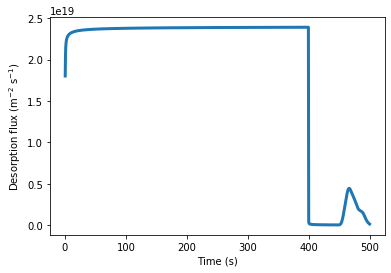

In [28]:
import matplotlib.pyplot as plt
plt.plot(t, flux_total, linewidth=3)

plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")

Make use of numpy to compute the time derivative of the traps inventories!

In [29]:
trap_1 = derived_quantities.filter(fields="1").data
trap_2 = derived_quantities.filter(fields="2").data
trap_3 = derived_quantities.filter(fields="3").data

contribution_trap_1 = -np.diff(trap_1)/np.diff(t)
contribution_trap_2 = -np.diff(trap_2)/np.diff(t)
contribution_trap_3 = -np.diff(trap_3)/np.diff(t)

We can now plot the TDS spectrum with the 3 traps contributions

Text(0.5, 0, 'Time (s)')

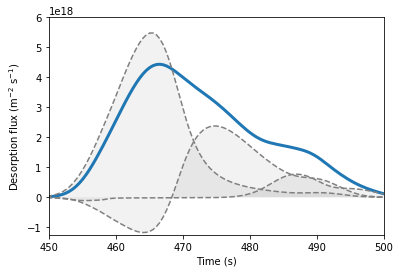

In [30]:
plt.plot(t, flux_total, linewidth=3)
plt.plot(t[1:], contribution_trap_1, linestyle="--", color="grey")
plt.fill_between(t[1:], 0, contribution_trap_1, facecolor='grey', alpha=0.1)
plt.plot(t[1:], contribution_trap_2, linestyle="--", color="grey")
plt.fill_between(t[1:], 0, contribution_trap_2, facecolor='grey', alpha=0.1)
plt.plot(t[1:], contribution_trap_3, linestyle="--", color="grey")
plt.fill_between(t[1:], 0, contribution_trap_3, facecolor='grey', alpha=0.1)

plt.xlim(450, 500)
plt.ylim(bottom=-1.25e18, top=0.6e19)
plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")

plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")

### Task:
1) Increase the implantation temperature to 500 K and see how the TDS spectrum is affected
2) Vary the detrapping energy of the first trap
3) At the end of the implantation phase, what is the proportion of hydrogen trapped in trap 2?

    <details>
    <summary>Show solution</summary>
    <br>
    Make use of the exported derived quantities.

    We computed the hydrogen inventory in traps 1, 2 and 3 as well as the mobile inventory.

    ```python
    t = derived_quantities.t
    trap_1 = derived_quantities.filter(fields="1").data
    trap_2 = derived_quantities.filter(fields="2").data
    trap_3 = derived_quantities.filter(fields="3").data
    mobile = derived_quantities.filter(fields="solute", instances=F.TotalVolume).data
    total = derived_quantities.filter(fields="retention").data

    plt.stackplot(t, trap_1, trap_2, trap_3, mobile)
    ```

    Try to run it!

    </details>
